In [13]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
import cv2
from skimage.metrics import structural_similarity as ss
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.ndimage import sobel

### Functions

In [14]:
def load_image(file_path):
    image = Image.open(file_path)
    matrix_image = np.array(image)
    return image, matrix_image

In [15]:
def display_colors(r, g, b):
    fig, ax = plt.subplots(1, 3, figsize=(14, 7))
    ax[0].imshow(r, cmap="Reds_r")
    ax[1].imshow(g, cmap="Greens_r")
    ax[2].imshow(b, cmap="Blues_r")
    for i in range(3):
        ax[i].axis('off')
    plt.tight_layout()

In [16]:
def svd_per_color(color, channel, svd_colors):
    U, Σ, V = np.linalg.svd(channel)
    svd_colors[color] = U, Σ, V
    return svd_colors, Σ

In [17]:
def compress_color(U, Σ, V, n_sv):
    U = U[:, :n_sv]
    Σ = Σ[:n_sv]
    V = V[:n_sv, :]
    compressed_color = np.dot(U, np.dot(np.diag(Σ), V))
    compressed_color = np.clip(compressed_color, 0, 255).astype('uint8')
    return Image.fromarray(compressed_color), Σ

In [18]:
def compress_image(svd_colors, n_sv):
    compressed_colors = []
    Σ_colors = {}
    for color in svd_colors:
        U, Σ, V = svd_colors[color]
        c_compressed, Σ_retained = compress_color(U, Σ, V, n_sv)
        compressed_colors.append(c_compressed)
        Σ_colors[color] = Σ_retained
    return Image.merge("RGB", compressed_colors)

In [19]:
def compute_compression_ratio(original_size, compressed_size):
    ratio = 1 - compressed_size/original_size
    print(f'Compression of {ratio * 100:.2f}%')

In [20]:
def plot_images(original_image, compressed_images, n_singular_values):
    fig, ax = plt.subplots(2, 2, figsize=(12, 7))
    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image')
    ax[0, 0].axis('off')
    for i, n_sv in enumerate(n_singular_values):
        compressed_image = compressed_images[i]
        ax[(i+1)//2, (i+1)%2].imshow(compressed_image)
        ax[(i+1)//2, (i+1)%2].set_title(f'Compressed image (number of SV = {n_sv})')
        ax[(i+1)//2, (i+1)%2].axis('off')
    plt.tight_layout()
    plt.show()

In [21]:
def plot_sv(Σ, c, n_sv):
    x = np.arange(1, n_sv + 1)
    plt.semilogy(x, Σ, c, linewidth=2, label=c)
    plt.grid()
    plt.xlabel('Number of Singular Values', fontsize=14)
    plt.ylabel(r'$\sigma_i$', fontsize=14)
    plt.title(f'Singular Values contribution per each channel (number of SV = {n_sv})', fontsize=16)

In [22]:
def plot_cumulative_energy(Σ, c, n_sv, title):
    x = np.arange(1, n_sv + 1)
    cumulative_energy = np.cumsum(Σ) / np.sum(Σ)
    plt.plot(x, cumulative_energy, c, linewidth=2, label=c)
    plt.grid()
    plt.xlabel('Number of Singular Values', fontsize=14)
    plt.ylabel('Cumulative Energy', fontsize=14)
    plt.title(title, fontsize=16)

In [23]:
def fsim_color(image1, image2):
    fsim_values = []
    for channel in range(3):
        fsim_values.append(fsim(image1[:, :, channel], image2[:, :, channel]))
    return np.mean(fsim_values)

def fsim(image1, image2):
    img1 = image1.astype(np.float32)
    img2 = image2.astype(np.float32)

    gradient_x1 = sobel(img1, axis=0)
    gradient_y1 = sobel(img1, axis=1)
    gradient_x2 = sobel(img2, axis=0)
    gradient_y2 = sobel(img2, axis=1)

    gradient_magnitude1 = np.sqrt(gradient_x1**2 + gradient_y1**2)
    gradient_magnitude2 = np.sqrt(gradient_x2**2 + gradient_y2**2)

    similarity_gradient = (2 * gradient_magnitude1 * gradient_magnitude2 + 1e-8) / \
                          (gradient_magnitude1**2 + gradient_magnitude2**2 + 1e-8)

    mu1 = cv2.GaussianBlur(img1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(img2, (11, 11), 1.5)
    similarity_luminance = (2 * mu1 * mu2 + 1e-8) / (mu1**2 + mu2**2 + 1e-8)

    fsim_map = similarity_gradient * similarity_luminance
    fsim_value = np.mean(fsim_map)

    return fsim_value

def evaluate_images(img1, img2):
    img1 = np.clip(img1, 0, 255).astype('uint8')
    img2 = np.array(img2)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    psnr_value = psnr(img1, img2, data_range=img1.max() - img1.min())
    print(f"PSNR: {psnr_value:.2f} dB")

    fsim_value = fsim_color(img1, img2)
    print(f"FSIM: {fsim_value:.4f}")

### Test

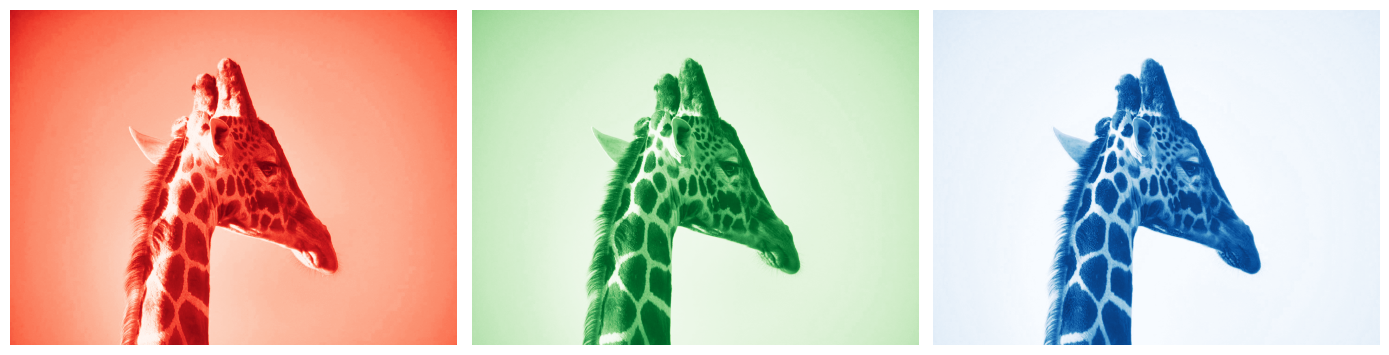

In [24]:
# Load the image and compute its size
image, matrix_image = load_image('giraffe.JPG')
m, n, c = matrix_image.shape
original_size = m * n * 3
max_sv = min(m, n)

# Split the image into RGB channels
matrix_image = matrix_image.astype(np.float64)
r, g, b = matrix_image[:, :, 0], matrix_image[:, :, 1], matrix_image[:, :, 2]
colors = {'Red': r, 'Green': g, 'Blue': b}
display_colors(r, g, b)

In [25]:
# Perform SVD for each channel
svd_colors = {}
Σ_colors = {}
for color in colors:
    channel = colors[color]
    svd_colors, Σ = svd_per_color(color, channel, svd_colors)
    Σ_colors[color] = Σ

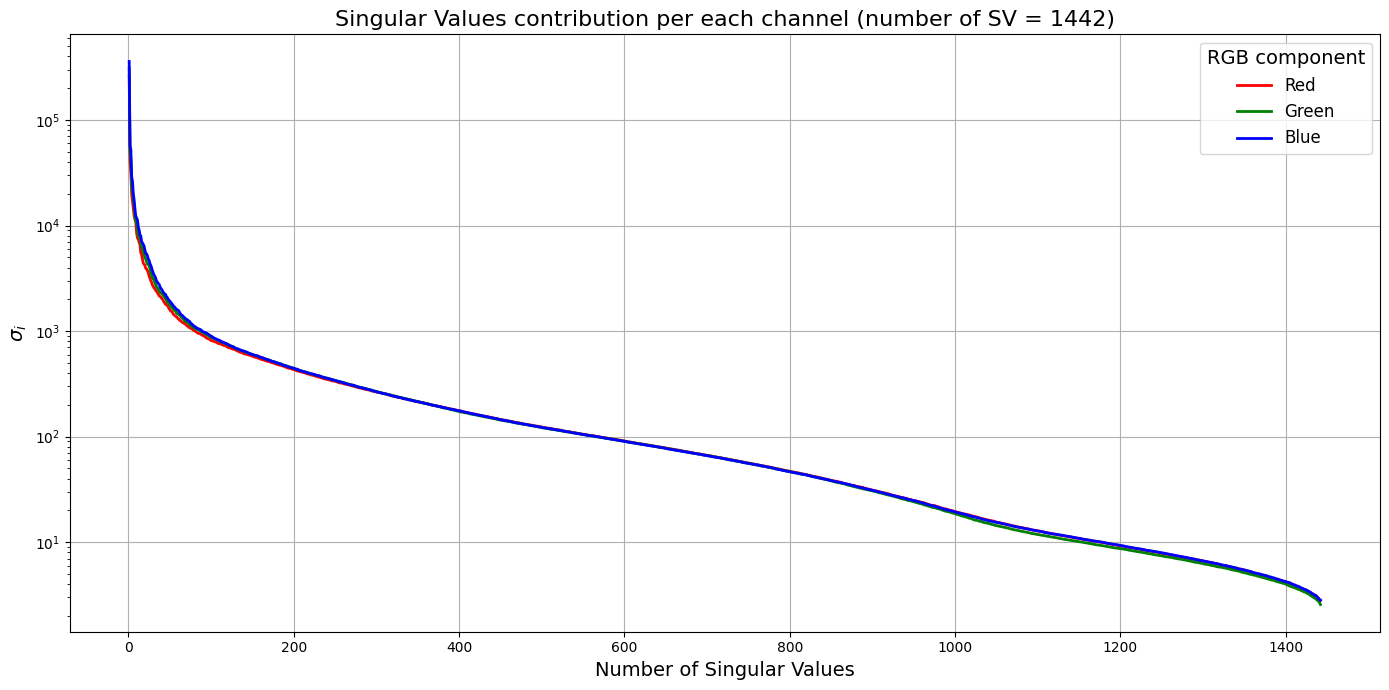

In [26]:
# Plot the contribution of all the Singular Values
plt.figure(figsize=(14, 7))
for c in Σ_colors:
    plot_sv(Σ_colors[c], c, max_sv)
plt.legend(title='RGB component', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

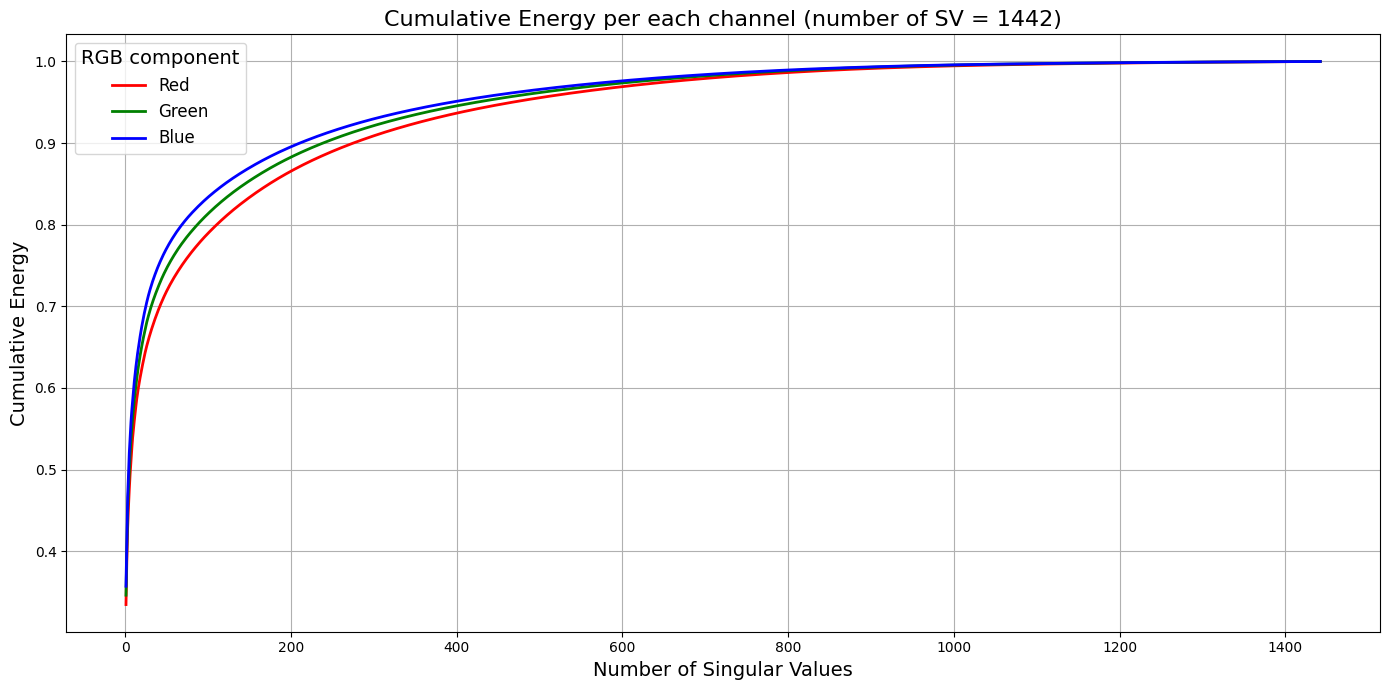

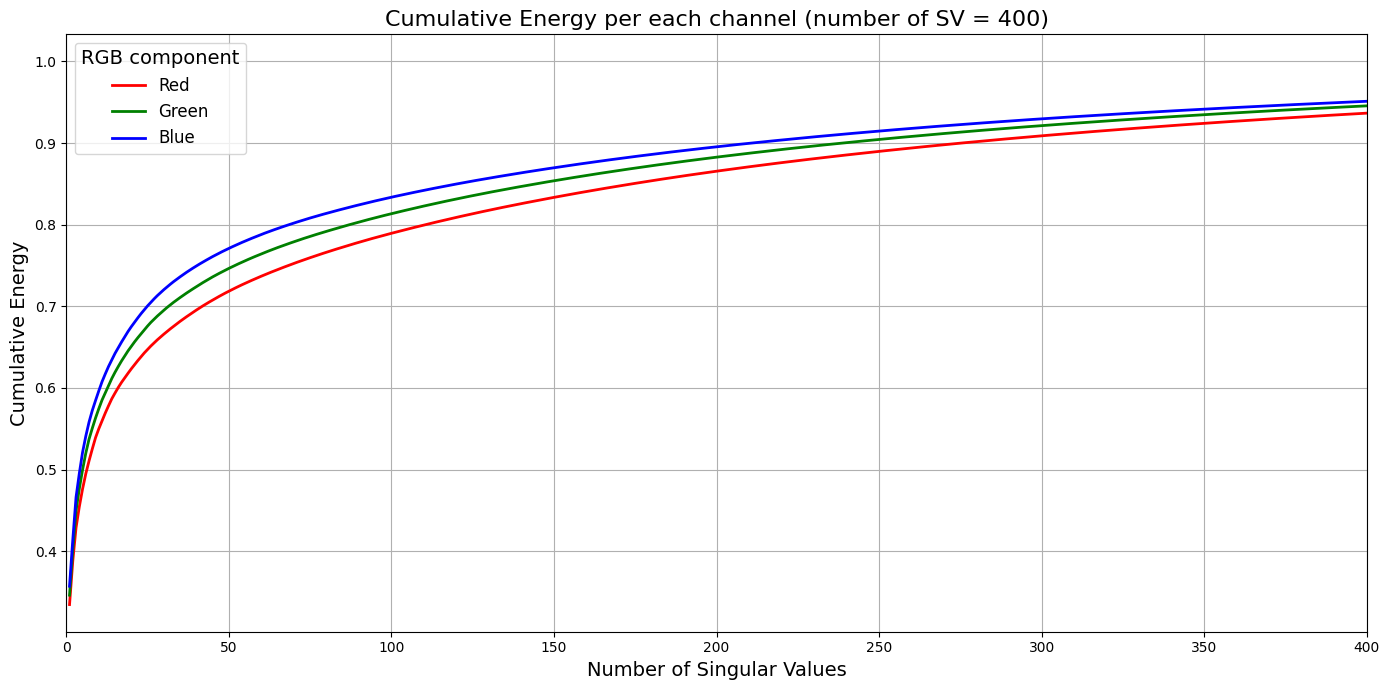

In [27]:
# Plot the cumulative energy of all the Singular Values
plt.figure(figsize=(14, 7))
for c in Σ_colors:
    plot_cumulative_energy(Σ_colors[c], c, max_sv, f'Cumulative Energy per each channel (number of SV = {max_sv})')
plt.legend(title='RGB component', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Plot the cumulative energy of the first 400 Singular Values
plt.figure(figsize=(14, 7))
for c in Σ_colors:
    plot_cumulative_energy(Σ_colors[c], c, max_sv, 'Cumulative Energy per each channel (number of SV = 400)')
plt.xlim(0, 400)
plt.legend(title='RGB component', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

In [28]:
# Define the number of singular values to use for compression
n_singular_values = [10, 50, 400]
compressed_images = []

for n_sv in n_singular_values:
    print('\nNumber of singular values:', n_sv)
    # Compress the image and compute its size as the number of SV multiplied with the sum of the dimensions of U, Σ and V
    compressed_size = n_sv * (1 + m + n) * 3
    compressed_image = compress_image(svd_colors, n_sv)

    # Save the output image
    # output_image = img_as_ubyte(compressed_image)
    # io.imsave(f'{n_sv}_compressed_image.jpg', output_image)

    compressed_images.append(compressed_image)

    # Compute and print the compression ratio
    print('Original image size:', original_size)
    print('Compressed image size:', compressed_size)
    compute_compression_ratio(original_size, compressed_size)


Number of singular values: 10
Original image size: 8305920
Compressed image size: 100890
Compression of 98.79%

Number of singular values: 50
Original image size: 8305920
Compressed image size: 504450
Compression of 93.93%

Number of singular values: 400
Original image size: 8305920
Compressed image size: 4035600
Compression of 51.41%


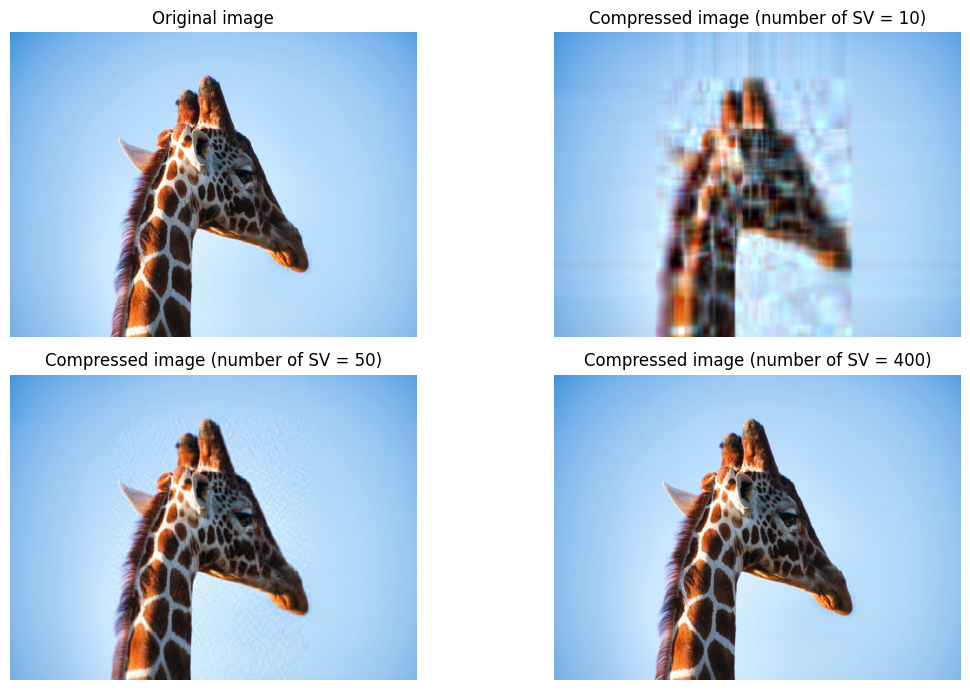

In [29]:
# Plot the original and compressed images
plot_images(image, compressed_images, n_singular_values)

In [30]:
# Evaluate the quality of the compressed images using PSNR and FSIM
for n_sv, img in zip(n_singular_values, compressed_images):  
    print(f"\nNumber of singular values: {n_sv}")
    evaluate_images(matrix_image, img)


Number of singular values: 10
PSNR: 23.13 dB
FSIM: 0.4510

Number of singular values: 50
PSNR: 31.34 dB
FSIM: 0.5577

Number of singular values: 400
PSNR: 45.27 dB
FSIM: 0.7712
